In [ ]:
# For google colab install MDAnalysis and MDAnalysisData
!pip install MDAnalysis MDAnalysisData

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 14.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 61.3 MB/s 
     |████████████████████████████████| 2.1 MB 54.7 MB/s 
     |████████████████████████████████| 374 kB 71.7 MB/s 
     |████████████████████████████████| 40 kB 29 kB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-2.1.0-cp37-cp37m-linux_x86_64.whl size=4652160 sha256=63489a2ea77c96d3072a2db2eb16734c80607eb870958b2be3bb8af1ff82c6e9
  Stored in directory: /root/.cache/pip/wheels/fa/dd/6b/9d51e7216a401b71949467a123e3b2dffba11256346f7f7bda
Successfully built MDAnalysis


This is a demonstration of network inference for protein dihedral angles using the inverse covariance technique. For ease of use, this demo uses MDAnalysis because it can be used in a self-contained way on Google CoLab. Some advantages of MDAnalysis are lazy-loading (not in RAM) and the test dataset (adenylate kinase equilibration). In reality though, we use MDTraj, because it has all the sidechain dihedral angles. In contrast, MDAnalysis only has chi1. 

Also, this simple demo does not use any of the custom python packages, increasing mess, reducing functionality. The purpose is to show that there is no magic behind inverting the covariance matrix.

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

In [ ]:
# If you need it, get data
import MDAnalysisData

In [ ]:
# If you need it, get data
# Download the dataset from MDAnalysisData
project_path = os.path.abspath('..')
rawdata_dir = os.path.join(project_path, 'rawdata_demo')
rawdata_path = os.path.join(rawdata_dir, 'adk_equilibrium')
if os.path.exists(rawdata_path):
    print("Looks like you already have the data.")
    topology_path = os.path.join(rawdata_path, 'adk4AKE.psf')
    trajectory_path = os.path.join(rawdata_path, '1ake_007-nowater-core-dt240ps.dcd')
    u = mda.Universe(topology_path, trajectory_path)
    pass
else:
    print("Downloading data from MDAnalysisData.")
    os.makedirs(rawdata_path, exist_ok=True)
    dataset = MDAnalysisData.adk_equilibrium.fetch_adk_equilibrium(
                    data_home=rawdata_dir)
    print(f"psf file in {dataset.topology}")
    print(f"dcd file in {dataset.trajectory}")
    u = mda.Universe(dataset.topology,
                 dataset.trajectory)

adk4AKE.psf: 795kB [00:01, 638kB/s]                           
1ake_007-nowater-core-dt240ps.dcd: 168MB [00:07, 23.9MB/s]                           


psf file in /rawdata_demo/adk_equilibrium/adk4AKE.psf
dcd file in /rawdata_demo/adk_equilibrium/1ake_007-nowater-core-dt240ps.dcd


In [ ]:
# MDAnalysis universe object
print(f"{u.trajectory.n_frames} frames")
print(f"{u.residues.n_residues} residues")

4187 frames
214 residues


# Get dihedrals

In [ ]:
# MDAnalysis atom groups to define dihedrals
ag_phi = u.residues.phi_selections()  # phi
ag_psi = u.residues.psi_selections()  # psi
ag_c1 = u.residues.chi1_selections()  # chi1 (sidechain)

# Actually get dihedral angle values
def remove_nodihe(ag_list):
    """Remove None from list, e.g. for phi of first residue, 
    psi of last residue
    """
    return list(filter(None, ag_list))

dihe = []
for ag in [ag_phi, ag_psi, ag_c1]:
    ag = remove_nodihe(ag)
    val = Dihedral(ag).run().results['angles']
    val = np.deg2rad(val)
    dihe.append(val)

# Make a num_frames by num_ang matrix
dihe = np.hstack(dihe)
print(f"dihe has shape {np.shape(dihe)}")

dihe has shape (4187, 551)


# Covariance and its inverse

In this simple example, we calculate the circular covariance and then invert it (the Moore-Penrose pseudo-inverse).  
Really, that's it!

In [ ]:
# Some circular statistics calculations. 

WRAP_LO = -np.pi
WRAP_HI = np.pi

def covmat(a, am=None, low=WRAP_LO, high=WRAP_HI):
    """circular statistic: covariance and cirrelation.
    NOTE: this is not the same as np.cov
    Arguments:
        a (TxN matrix): angle
        am (1xN matrix, optional): reference angle, usually average
    Returns:
        cicov (NxN matrix): covariance
    """
    if am is None:
        am = avg(a, axis=0, low=low, high=high)
    a_diff = _subtract_mean(a, am, low, high)
    sin = np.sin(a_diff)
    T = np.shape(a)[0]
    cicov = np.matmul(sin.T, sin) / (T-1)  # do NOT replace with np.cov
    return cicov

def avg(a, axis=0, low=WRAP_LO, high=WRAP_HI):
    """Wrapper for scipy circular average"""
    am = sp.stats.circmean(a, axis=0, low=low, high=high)
    return am

def dist(a, b):
    """Angular difference,
    https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles
    """
    ang_diff = np.arctan2(np.sin(a - b), np.cos(a - b))
    return ang_diff


def _subtract_mean(a, am, low=WRAP_LO, high=WRAP_HI):
    """Helper function to do a - am.
    """
    a_diff = dist(a, am)
    return a_diff

In [ ]:
covariance = covmat(dihe)

In [ ]:
inv_covariance = np.linalg.pinv(covariance)

In [ ]:
ind_triu = np.triu_indices_from(covariance, k=1)

vmaxile = 97
covariance_max = np.percentile(np.abs(covariance[ind_triu]), vmaxile)
inv_covariance_max = np.percentile(np.abs(inv_covariance[ind_triu]), vmaxile)

In [ ]:
print(f"For visualization, will set to value at {vmaxile}%ile")
print(f"Covariance max is {covariance_max}")
print(f"Inverse covariance max is {inv_covariance_max :.2f}")

For visualization, will set to value at 97%ile
Covariance max is 0.01190770632559502
Inverse covariance max is 9.78


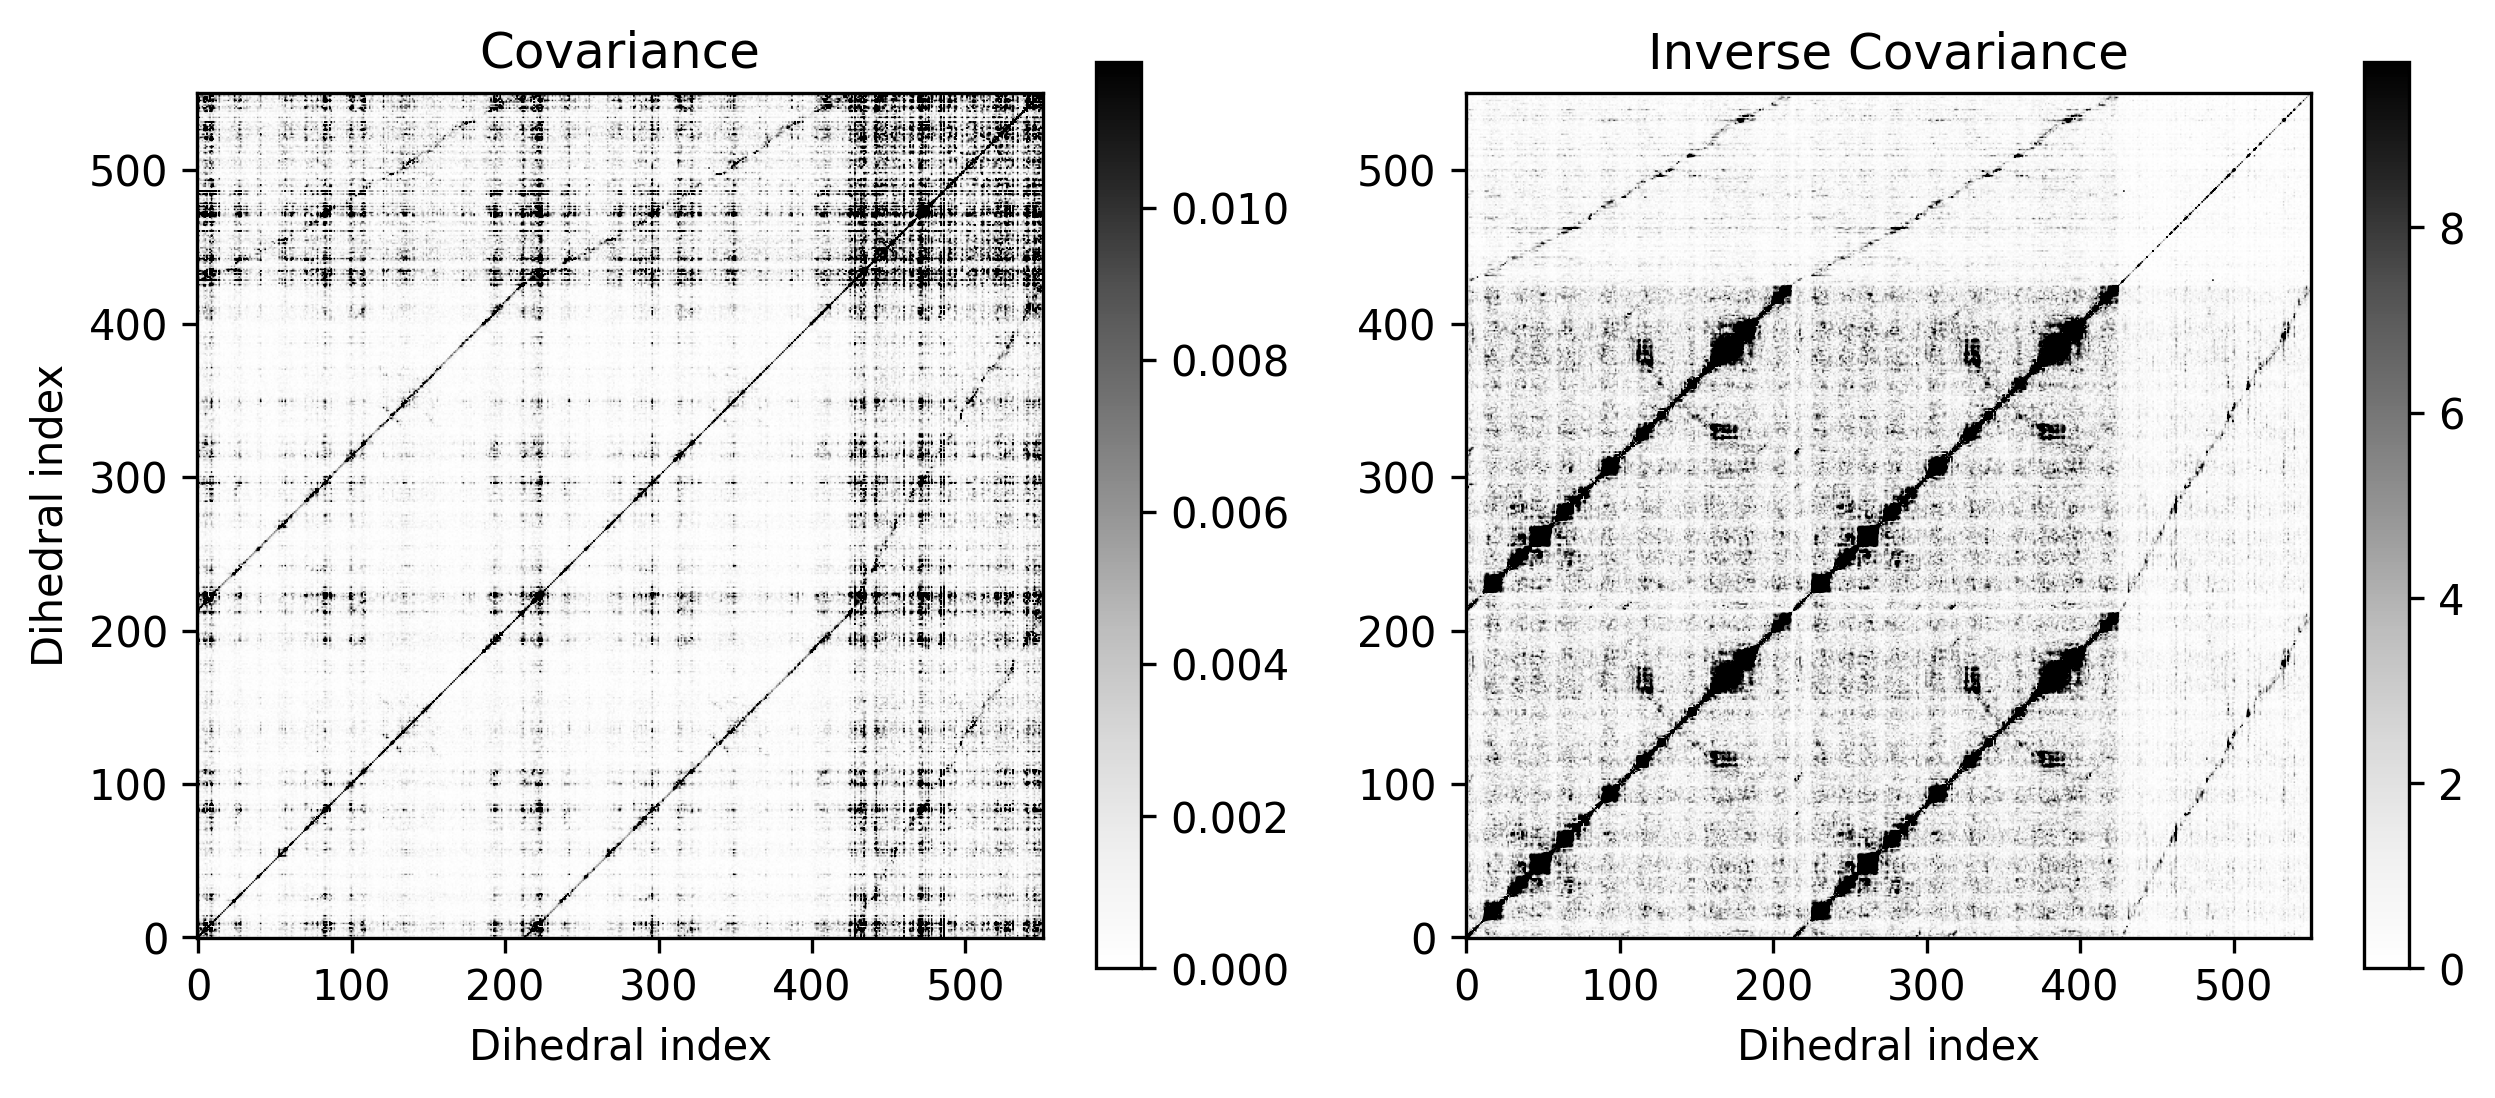

In [ ]:
fig, (ax_cov, ax_invcov) = plt.subplots(1,2, figsize=[10, 4], dpi=300)
im_cov = ax_cov.imshow(np.abs(covariance), 
                       vmin=0, vmax=covariance_max, 
                       cmap='Greys')
plt.colorbar(im_cov, ax=ax_cov)

im_invcov = ax_invcov.imshow(np.abs(inv_covariance), 
                               vmin=0, vmax=inv_covariance_max, 
                               cmap='Greys')
plt.colorbar(im_invcov, ax=ax_invcov)

for ax in [ax_cov, ax_invcov]:
    ax.invert_yaxis()
    ax.set_xlabel('Dihedral index')
#
ax_cov.set_ylabel('Dihedral index')
ax_cov.set_title('Covariance')
ax_invcov.set_title('Inverse Covariance')
plt.show()

Note the very different patterns for (left) the covariance matrix and (right) its inverse. In the covariance matrix, sidechain-sidechain interactions domainte. In addition, there are dark 'bands', which are dihedral angles that correlate with many other dihedrals across the protein.  

In contrast, in the inverse covariance matrix, the backbone-backbone interactions dominate. The pattern that repeats 4 times is for the phi-phi, phi-psi, psi-phi, and psi-psi interactions. It looks a lot like the contact map of the protein. 

The colormap maximum is set to the vmaxile = 97%ile. 